In [1]:
import re, sys, os
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import warnings
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import rdChemReactions, AllChem, Draw, PandasTools
from torch.utils.data import Dataset, DataLoader

RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Load dataset + model

In [2]:
df_test = pd.read_pickle("../data/transformed/test_dataset.pkl")

In [3]:
class Encoder(nn.Module):
    def __init__(self, vocab, d_model=384, n_layers=2, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=0)
        self.rnn = nn.GRU(d_model, d_model, num_layers=n_layers, batch_first=True, dropout=dropout)
    def forward(self, x):
        x = self.emb(x)
        out, h = self.rnn(x)
        return out, h

class Decoder(nn.Module):
    def __init__(self, vocab, d_model=384, n_layers=2, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=0)
        self.rnn = nn.GRU(d_model, d_model, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.proj = nn.Linear(d_model, vocab)
    def forward(self, y_in, h):
        y = self.emb(y_in)
        out, h = self.rnn(y, h)
        logits = self.proj(out)
        return logits, h

class Seq2Seq(nn.Module):
    def __init__(self, vocab, d_model=384, n_layers=2, dropout=0.1):
        super().__init__()
        self.enc = Encoder(vocab, d_model, n_layers, dropout)
        self.dec = Decoder(vocab, d_model, n_layers, dropout)
    def forward(self, src, tgt_in):
        _, h = self.enc(src)
        logits, _ = self.dec(tgt_in, h)
        return logits

def encode(smiles, stoi, max_len=128):
    # returns list of token IDs with <s> at start, </s> at end, padded
    ids = [stoi["<s>"]] + [stoi[ch] for ch in smiles] + [stoi["</s>"]]
    if len(ids) < max_len:
        ids += [stoi["<pad>"]] * (max_len - len(ids))
    return ids[:max_len]

def decode(ids, itos):
    # returns string ignoring special tokens
    chars = [itos[i] for i in ids if itos[i] not in ("<pad>", "<s>", "</s>")]
    return "".join(chars)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load("../models/seq2seq_gru_bbs.pt", map_location=device)

# Re-create the model
vocab_size = len(checkpoint['stoi'])
model = Seq2Seq(vocab=vocab_size, d_model=384, n_layers=2, dropout=0.1)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Tokenizer dictionaries
stoi = checkpoint['stoi']
itos = checkpoint['itos']

In [5]:
class Encoder(nn.Module):
    def __init__(self, vocab, d_model=384, n_layers=2, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=0)
        self.rnn = nn.GRU(d_model, d_model, num_layers=n_layers, batch_first=True, dropout=dropout)
    def forward(self, x):
        x = self.emb(x)
        out, h = self.rnn(x)
        return out, h

class Decoder(nn.Module):
    def __init__(self, vocab, d_model=384, n_layers=2, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=0)
        self.rnn = nn.GRU(d_model, d_model, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.proj = nn.Linear(d_model, vocab)
    def forward(self, y_in, h):
        y = self.emb(y_in)
        out, h = self.rnn(y, h)
        logits = self.proj(out)
        return logits, h

class Seq2Seq(nn.Module):
    def __init__(self, vocab, d_model=384, n_layers=2, dropout=0.1):
        super().__init__()
        self.enc = Encoder(vocab, d_model, n_layers, dropout)
        self.dec = Decoder(vocab, d_model, n_layers, dropout)
    def forward(self, src, tgt_in):
        _, h = self.enc(src)
        logits, _ = self.dec(tgt_in, h)
        return logits

#### Predict

In [6]:
def predict_bbs(model, src_smiles, stoi, itos, max_len=128, device=device):
    model.eval()
    src_ids = torch.tensor([encode(src_smiles, stoi, max_len)]).to(device)
    
    # --- Encode once
    _, h = model.enc(src_ids)
    
    # --- Decoder starts with <s>
    tgt_ids = torch.tensor([[stoi["<s>"]]], device=device)
    pred_tokens = []

    for _ in range(max_len):
        logits, h = model.dec(tgt_ids, h)
        next_token = logits[:, -1, :].argmax(-1, keepdim=True)
        if next_token.item() == stoi["</s>"]:
            break
        pred_tokens.append(next_token.item())
        tgt_ids = torch.cat([tgt_ids, next_token], dim=1)

    pred_bbs = "".join([itos[i] for i in pred_tokens])
    return pred_bbs

In [7]:
for i in range(10):
    mol_smi = df_test['mol_smi'].iloc[i]
    true_bbs = df_test['bbs_smi'].iloc[i]
    pred_bbs = predict_bbs(model, mol_smi, stoi, itos)
    print(f"MOL  : {mol_smi}")
    print(f"TRUE : {true_bbs}")
    print(f"PRED : {pred_bbs}\n")

MOL  : COc1cccc(F)c1[C@@H]1C[C@H](Cl)C(=O)N1Cc1cccc(OC(F)(F)C(F)F)c1
TRUE : [*]c1c(F)cccc1OC.[*][C@]1([H])C[C@]([H])(Cl)C(=O)N1[*].[*]Cc1cccc(OC(F)(F)C(F)F)c1
PRED : [*]c1c(F)cccc1OC.[*][C@]1([H])C[C@]([H])(C)C(=O)N1[*].[*]Cc1ccc2sc(C)n2)c1

MOL  : COc1cccc(OC)c1[C@@H]1CCCC(=O)N1Cc1cccc(-n2nccn2)c1
TRUE : [*]c1c(OC)cccc1OC.[*][C@]1([H])CCCC(=O)N1[*].[*]Cc1cccc(-n2nccn2)c1
PRED : [*]c1c(OC)ccc2ccc(=O)oc12.[*][C@]1([H])CCCC(=O)N1[*].[*]Cc1ccc2ccccc2n1

MOL  : COc1cccc(OC)c1[C@@H]1[C@@H](C(=O)O)CCC(=O)N1Cc1ccc(OC(F)(F)F)cc1
TRUE : [*]c1c(OC)cccc1OC.[*][C@@]1([H])N([*])C(=O)CC[C@]1([H])C(=O)O.[*]Cc1ccc(OC(F)(F)F)cc1
PRED : [*]c1c(OC)cccc1OC(F)F.[*][C@]1([H])C[C@]([H])(C)C(=O)N1[*].[*]Cc1cccc(-c2csc(C)n2)c1

MOL  : COc1cccc(OC)c1[C@@H]1C[C@H](C)C(=O)N1Cc1cccc(-n2cccn2)n1
TRUE : [*]c1c(OC)cccc1OC.[*][C@]1([H])C[C@]([H])(C)C(=O)N1[*].[*]Cc1cccc(-n2cccn2)n1
PRED : [*]c1c(OC)cccc1-c1ccccc1.[*][C@]1([H])CCC(=O)N1[*].[*]Cc1cccc(-c2ccccc2)c1

MOL  : C[C@H]1C[C@@H](c2c(O)cccc2F)N(Cc2ccc(OC(F)(F)F)c

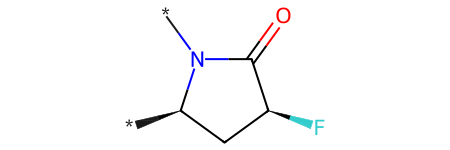

In [20]:
Chem.MolFromSmiles('[*][C@]1([H])C[C@]([H])(F)C(=O)N1[*]')

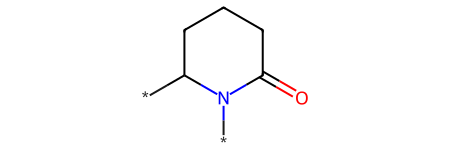

In [19]:
Chem.MolFromSmiles('[*]C1CCCC(=O)N1[*]')

In [10]:
def canonize_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol, canonical=True)

In [11]:
results = []
for i in range(len(df_test)):
    mol_smi = df_test['mol_smi'].iloc[i]
    true_a = df_test['A_smi'].iloc[i]
    pred_a = predict_bbs(model, mol_smi, stoi, itos).split('.')[0]  # first fragment as example
    
    true_can = canonize_smiles(true_a)
    pred_can = canonize_smiles(pred_a)
    
    exact_match = true_can == pred_can
    
    results.append({
        'mol_smi': mol_smi,
        'true_a': true_a,
        'pred_a': pred_a,
        'true_can': true_can,
        'pred_can': pred_can,
        'exact_match': exact_match
    })

df_compare = pd.DataFrame(results)

In [12]:
df_compare

,mol_smi,true_a,pred_a,true_can,pred_can,exact_match
0,COc1cccc(F)c1[C@@H]1C[C@H](Cl)C(=O)N1Cc1cccc(O...,[*]c1c(F)cccc1OC,[*]c1c(F)cccc1OC,*c1c(F)cccc1OC,*c1c(F)cccc1OC,True
1,COc1cccc(OC)c1[C@@H]1CCCC(=O)N1Cc1cccc(-n2nccn...,[*]c1c(OC)cccc1OC,[*]c1c(OC)ccc2ccc(=O)oc12,*c1c(OC)cccc1OC,*c1c(OC)ccc2ccc(=O)oc12,False
2,COc1cccc(OC)c1[C@@H]1[C@@H](C(=O)O)CCC(=O)N1Cc...,[*]c1c(OC)cccc1OC,[*]c1c(OC)cccc1OC(F)F,*c1c(OC)cccc1OC,*c1c(OC)cccc1OC(F)F,False
3,COc1cccc(OC)c1[C@@H]1C[C@H](C)C(=O)N1Cc1cccc(-...,[*]c1c(OC)cccc1OC,[*]c1c(OC)cccc1-c1ccccc1,*c1c(OC)cccc1OC,*c1c(OC)cccc1-c1ccccc1,False
4,C[C@H]1C[C@@H](c2c(O)cccc2F)N(Cc2ccc(OC(F)(F)F...,[*]c1c(O)cccc1F,[*]c1c(C)cccc1OC,*c1c(O)cccc1F,*c1c(C)cccc1OC,False
5,CCOc1ccc(F)c(F)c1[C@@H]1C[C@@H](O)C(=O)N1Cc1cc...,[*]c1c(OCC)ccc(F)c1F,[*]c1c(OCC)ccc(F)c1F,*c1c(OCC)ccc(F)c1F,*c1c(OCC)ccc(F)c1F,True
6,COc1cccc(OC)c1[C@@H]1CCCCC(=O)N1Cc1cccc(-c2cnc...,[*]c1c(OC)cccc1OC,[*]c1c(OC)ccc2ccc(=O)oc12,*c1c(OC)cccc1OC,*c1c(OC)ccc2ccc(=O)oc12,False
7,COc1cccc(OC)c1[C@@H]1CCCC(=O)N1Cc1cn2ccccc2n1,[*]c1c(OC)cccc1OC,[*]c1c(OC)ccc2ccc(=O)oc12,*c1c(OC)cccc1OC,*c1c(OC)ccc2ccc(=O)oc12,False
8,COc1ccc2c(c1[C@@H]1CCCC(=O)N1Cc1ccc(OC(F)(F)F)...,[*]c1c(OC)ccc2c1OCO2,[*]c1c(OC)cccc1OC,*c1c(OC)ccc2c1OCO2,*c1c(OC)cccc1OC,False
9,COc1cccc(OCC(F)F)c1[C@H]1C[C@H](O)C(=O)N1Cc1cc...,[*]c1c(OC)cccc1OCC(F)F,[*]c1c(OC)ccc(Cl)c1F,*c1c(OC)cccc1OCC(F)F,*c1c(OC)ccc(Cl)c1F,False


In [21]:
Chem.MolFromSmiles('[*]c1c(OC)ccc2c1OCCO')

In [ ]:
def mol_to_image(smiles, size=(200,200)):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return Draw.MolToImage(mol, size=size)

In [ ]:
df_test = df_val.head(10)

In [ ]:
rows = []
for i in range(len(df_test)):
    mol_smi = df_test['mol_smi'].iloc[i]
    true_bbs = df_test['bbs_smi'].iloc[i]
    pred_bbs = predict_bbs(model, mol_smi, stoi, itos)
    
    rows.append({
        'Molecule': mol_to_image(mol_smi),
        'True BBS': mol_to_image(true_bbs.split('.')[0]),  # optionally only first fragment
        'Pred BBS': mol_to_image(pred_bbs.split('.')[0])
    })

df_vis = pd.DataFrame(rows)
df_test

In [ ]:
from IPython.display import display
for i, row in df_vis.iterrows():
    display(row['Molecule'])
    display(row['True BBS'])
    display(row['Pred BBS'])